# Project_1_Demand_Forecasting

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import time

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

Through the previous cell, the packages necessary to perform the following code are downloaded.

## Loading the Data

In [ ]:
demand_forecasting_data = pd.read_csv('demand_forecasting_data.csv')

demand_forecasting_data

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52
...,...,...,...,...,...,...,...,...,...
150145,212638,09/07/13,9984,223245,235.8375,235.8375,0,0,38
150146,212639,09/07/13,9984,223153,235.8375,235.8375,0,0,30
150147,212642,09/07/13,9984,245338,357.6750,483.7875,1,1,31
150148,212643,09/07/13,9984,547934,141.7875,191.6625,0,1,12


## Explorative Data Analysis (EDA)

From the EDA it is possible to understand the distributions and the nature of our variables. By plotting the distributions of the variables, we can see how it is necessary  to work on the variables store_is and sku_id, because of their long tails, then we use the one hot encoding to manage these variables.

The 1 hot encoding improves sensibly the performances of the model, from accuracy of 0.75 and a root mse of 17.9 in the base model to accuracy of 0.91 and a root mse of 12.7 in the base model. It works well in this case because, as loong as the Random Forest is based on thresholds, avoids it to create meaningless thresholds related to the ids of the stores, which do not contain information per se, and allows the model to learn specific patterns related to the specific store.

<function matplotlib.pyplot.show(close=None, block=None)>

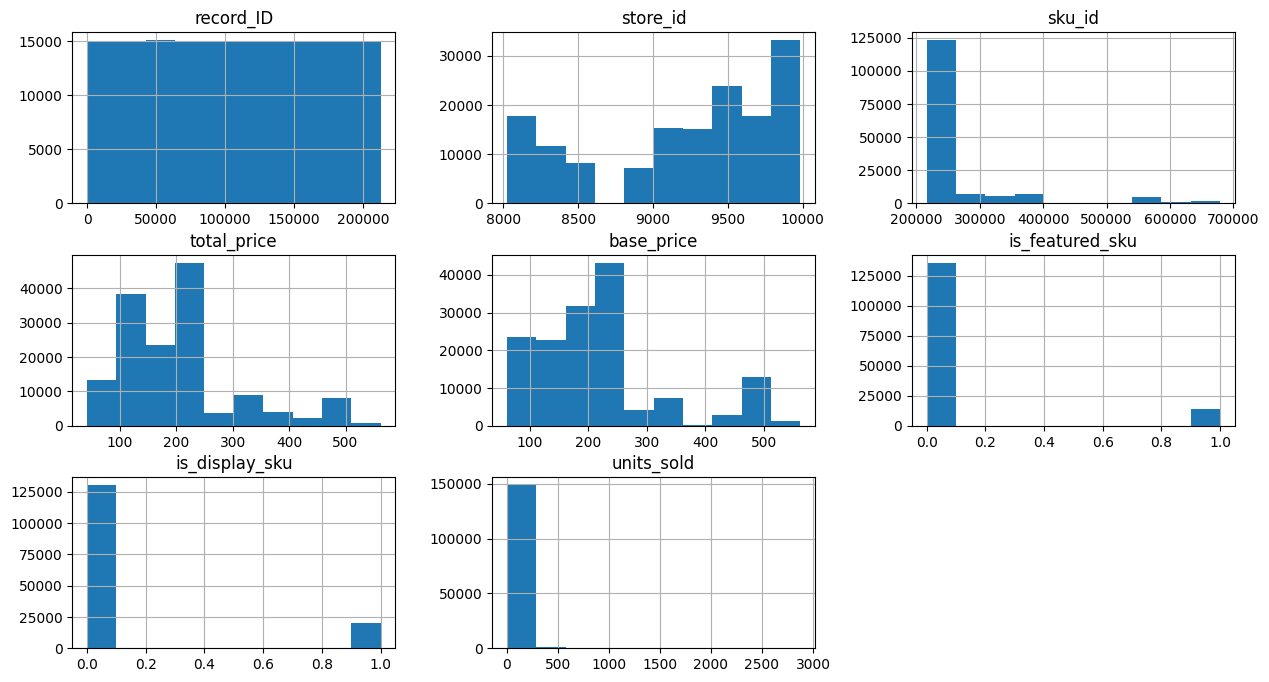

In [ ]:
demand_forecasting_data.hist(figsize=(15, 8))
plt.show

The variable "units_sold" doesn't have a nice distribution, to manage it all the values below the 99th quantile are removed.

## Preprocessing

In [ ]:
demand_forecasting_data = demand_forecasting_data[demand_forecasting_data.units_sold < demand_forecasting_data.units_sold.quantile(0.99)] # line to remove all the values below the 99th quantile

# 1 hot encoding for the variable store_id
demand_forecasting_data = demand_forecasting_data.join(pd.get_dummies(demand_forecasting_data.store_id, prefix = 'store'))
demand_forecasting_data = demand_forecasting_data.drop(['store_id'], axis = 1)

# 1 hot encoding for the variable sku_id
demand_forecasting_data = demand_forecasting_data.join(pd.get_dummies(demand_forecasting_data.sku_id, prefix = 'item'))
demand_forecasting_data = demand_forecasting_data.drop(['sku_id'], axis = 1)

# drop the column week and record_ID
demand_forecasting_data = demand_forecasting_data.drop(['week'], axis =1)
demand_forecasting_data = demand_forecasting_data.drop(['record_ID'], axis =1)

demand_forecasting_data

,total_price,base_price,is_featured_sku,is_display_sku,units_sold,store_8023,store_8058,store_8063,store_8091,store_8094,...,item_320485,item_327492,item_378934,item_398721,item_545621,item_546789,item_547934,item_600934,item_673209,item_679023
0,99.0375,111.8625,0,0,20,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,99.0375,99.0375,0,0,28,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,133.9500,133.9500,0,0,19,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,133.9500,133.9500,0,0,44,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,141.0750,141.0750,0,0,52,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150145,235.8375,235.8375,0,0,38,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
150146,235.8375,235.8375,0,0,30,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
150147,357.6750,483.7875,1,1,31,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
150148,141.7875,191.6625,0,1,12,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


## Models

In [ ]:
X, Y = demand_forecasting_data.drop(['units_sold'], axis =1), demand_forecasting_data['units_sold']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

### 1. Random Forest without GridSearch

In [ ]:
model_random_forest_without_hp_t = RandomForestRegressor(n_jobs = -1)
model_random_forest_without_hp_t.fit(X_train, Y_train)

# results

# print the R^2 score for the model without hy t
model_random_forest_without_hp_t_R_2_score = model_random_forest_without_hp_t.score(X_test, Y_test) # R^2 score
print(model_random_forest_without_hp_t_R_2_score)

# print the root mean squared error (MSE) for the model without hy t
Y_pred_model_random_forest_without_hp_t = model_random_forest_without_hp_t.predict(X_test)
root_MSE_model_random_forest_without_hp_t = root_mean_squared_error(Y_pred_model_random_forest_without_hp_t, Y_test)
print(root_MSE_model_random_forest_without_hp_t)

0.7819467827354734
19.93287075920483


### 2. Random Forest with GridSearch

In [ ]:
# parameters setting
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 4]
}

model_random_forest_with_hp_t = RandomForestRegressor(n_jobs = -1)
grid_search_random_forest_with_hp_t = GridSearchCV(model_random_forest_with_hp_t, param_grid, verbose = 2, cv = 3)
grid_search_random_forest_with_hp_t.fit(X_train, Y_train)

# results

# print the best estimator combination
best_model_random_forest_with_hp_t = grid_search_random_forest_with_hp_t.best_estimator_
print(best_model_random_forest_with_hp_t)

# print the best parameters combination
best_parameters_random_forest_with_hp_t = grid_search_random_forest_with_hp_t.best_params_
print(best_parameters_random_forest_with_hp_t)

# print the R^2 score for the best estimator model
best_model_random_forest_with_hp_t_R_2_score = best_model_random_forest_with_hp_t.score(X_test, Y_test) # R^2 score
print(best_model_random_forest_with_hp_t_R_2_score)

# print the root mean squared error (MSE) for the best estimator model
Y_pred_model_random_forest_with_hp_t = best_model_random_forest_with_hp_t.predict(X_test)
root_MSE_best_model_random_forest_with_hp_t = root_mean_squared_error(Y_pred_model_random_forest_with_hp_t, Y_test)
print(root_MSE_best_model_random_forest_with_hp_t)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=  29.4s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=  29.6s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=  29.3s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=  58.7s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=  58.8s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time= 1.0min
[CV] END max_depth=10, min_samples_split=4, n_estimators=100; total time=  29.4s
[CV] END max_depth=10, min_samples_split=4, n_estimators=100; total time=  31.9s
[CV] END max_depth=10, min_samples_split=4, n_estimators=100; total time=  29.1s
[CV] END max_depth=10, min_samples_split=4, n_estimators=200; total time=  56.9s
[CV] END max_depth=10, min_samples_split=4, n_estimators=200; total time=  56.5s
[CV] END max_depth=10, min_samples_split=4, n_est

### 3. XGBoost

In [ ]:
model_xgboost = xgb.XGBRegressor(n_estimators = 200, max_depth = 10)
model_xgboost.fit(X_train, Y_train)

# results

# print the R^2 score for the model xgboost
model_xgboost_R_2_score = model_xgboost.score(X_test, Y_test)
print(model_xgboost_R_2_score)

# print the root mean squared error (MSE) for the model xgboost
Y_pred_model_xgboost = model_xgboost.predict(X_test)
root_MSE_model_xgboost = root_mean_squared_error(Y_pred_model_xgboost, Y_test)
print(root_MSE_model_xgboost)

0.8069685101509094
18.754379272460938


## Comparison between models' performances

In [ ]:
MAE_model_random_forest_without_hp_t = mean_absolute_error(Y_test, Y_pred_model_random_forest_without_hp_t)
MAE_model_random_forest_with_hp_t = mean_absolute_error(Y_test, Y_pred_model_random_forest_with_hp_t)
MAE_model_xgboost = mean_absolute_error(Y_test, Y_pred_model_xgboost)

results_comparison_dataset = pd.DataFrame({
    'Model': ['Random Forest (base)', 'Random Forest (optimized)', 'XGBoost'],
    'R2 Score': [
        model_random_forest_without_hp_t_R_2_score,
        best_model_random_forest_with_hp_t_R_2_score,
        model_xgboost_R_2_score
    ],
    'RMSE': [
        root_MSE_model_random_forest_without_hp_t,
        root_MSE_best_model_random_forest_with_hp_t,
        root_MSE_model_xgboost
    ],
    'MAE': [
        MAE_model_random_forest_without_hp_t,
        MAE_model_random_forest_with_hp_t,
        MAE_model_xgboost]
})

results_comparison_dataset

,Model,R2 Score,RMSE,MAE
0,Random Forest (base),0.781947,19.932871,12.630447
1,Random Forest (optimized),0.719805,22.595329,15.358385
2,XGBoost,0.806969,18.754379,12.015479


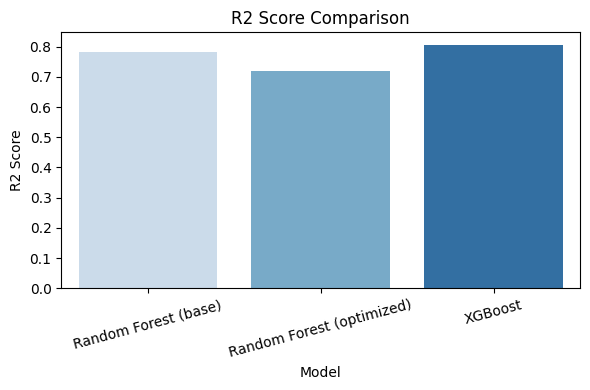

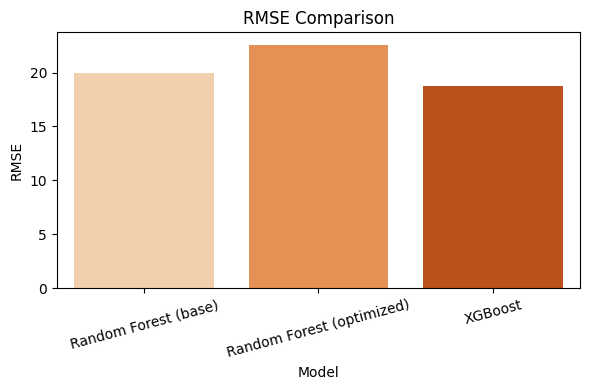

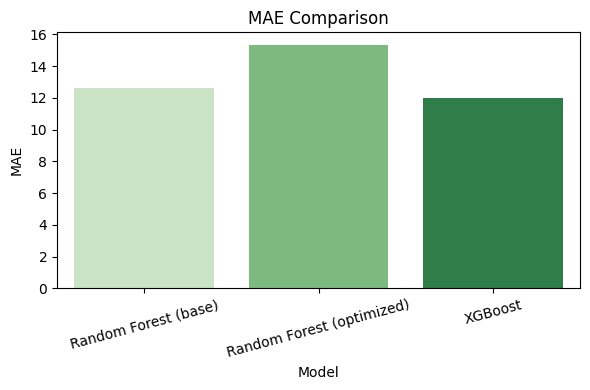

In [ ]:
palette_dict = {
    'R2 Score': 'Blues',
    'RMSE': 'Oranges',
    'MAE': 'Greens'
}

metrics = ['R2 Score', 'RMSE', 'MAE']

for metric in metrics:
    plt.figure(figsize=(6, 4))

    sns.barplot(
        data = results_comparison_dataset,
        x = 'Model',
        y = metric,
        hue = 'Model',
        palette = sns.color_palette(palette_dict[metric], n_colors=len(results_comparison_dataset)),
        legend = False
    )

    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()